# 🫁 EXP 09 폐렴 진단기 성능 개선



* 이번시간에는 폐의 X-RAY 사진 데이터셋을 가져와, CNN 모델을 구축하여 불균형한 데이터셋을 균일화 하고, 데이터셋을 만들어, 구축한 모델로 X-RAY 사진에 있는 특징을 통해 학습하고, 폐렴을 판단 해 보았습니다. 
* lms 상에서 만들었던 모델을 다시 만들어보고, 여러가지 개선점을 도입해 모델의 성능을 개선 해 보겠습니다.

# 루브릭 평가 기준 


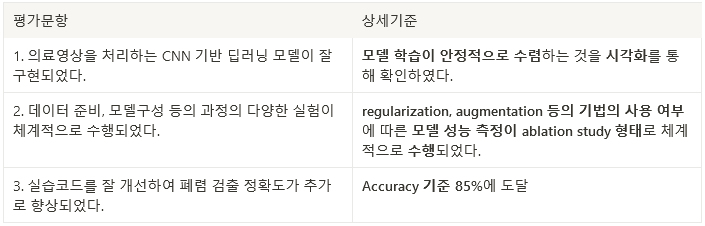




----




# 목차 


## 1. 필요한 데이터, 라이브러리 불러오기

## 2. 데이터셋 다듬기

## 3. 모델 구축하고 훈련하기 

## 4. 모델 성능 평가하기

## 5. 모델 성능 향상해보기

## 📋  회고

## 🔗 참고 페이지 




----




# 1. 필요한 데이터, 라이브러리 불러오기

## 1-1 라이브러리 불러오기 




In [3]:
# 필요한 라이브러리 가져오기 

import os, re, random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

#EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 1-2 필요한 변수 생성하기

* 모델 생성 및 데이터 불러오기에 필요한 변수를 생성합니다. 

In [4]:
# 데이터를 로드할 때 빠르게 로드할 수 있도록 하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## 1-3 데이터 가져오기 


* [Chest X-Ray Images 데이터셋](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)을 사용합니다. 

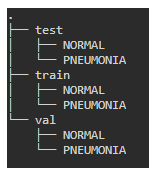  
* 데이터셋은 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5세 소아환자 흉부 X선 영상. 
* 총 5863개의 X-RAY 이미지와 2개의 범주 (정상/폐렴)이 있으며, train, validation, test 3개의 폴더에 각각 정상/폐렴 으로 나뉜 폴더가 있습니다.
* 데이터 셋 총 크기는 약 1.2GB 

In [5]:
# 데이터 개수를 확인 

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print('train data : ',len(train_filenames))
print('test data : ',len(test_filenames))
print('validation data : ',len(val_filenames))

train data :  5216
test data :  624
validation data :  16






----





# 2. 데이터셋 다듬기


* 불러온 데이터셋의 개수를 확인 해 보니, validation 데이터의 개수가 현저히 적었다. train data와 validation data를 합친 다음, 8:2 비율로 나눠줘야한다. 

 
* train data 내 정상/폐렴 데이터수를 확인 해봅시다. 데이터의 비율은 균등한가요?

 
* 모델의 학습이 잘 됬는지를 판단하기 위해선 꼭 label data가 필요하므로, 데이터 라벨링 작업이 필요합니다. 

 
* tf.data 인스턴스를 이용해, train과 validation을 구성한 후 이미지의 size를 동일하게 맞춰주고, 사이즈도 줄여봅시다. 이미지의 size를 줄이면 GPU 메모리를 더 효율적으로 사용할 수 있답니다. 균일화도 하고, 사이즈도 맞춰주고! 1석 2조네! 




## &nbsp; &nbsp; 2-1 데이터셋 나눠주기 

* train data와 validation data의 비율을 8:2로 맞춰주겠습니다. 
* 우선 두 데이터를 합친 후, 8:2 비율로 나눠줍니다. 

In [6]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('train data : ',len(train_filenames))
print('validation data : ',len(val_filenames))
print('test data : ',len(test_filenames))

train data :  4185
validation data :  1047
test data :  624


## &nbsp; &nbsp; 2-2 train data 확인하기 

* train data 내 정상/폐렴 데이터가 균일한지 한번 알아보겠습니다. 
* validation, test 데이터는 검증을 위한 데이터이기 때문에 균등하지 않아도 괜찮습니다:) 

In [7]:
# 정상 이미지와 폐렴 이미지 파일 이름을 확인 해 볼까요?

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


* ```정상``` 인 폴더의 이미지 파일 이름엔 NORMAL이, ```폐렴``` 인 폴더의 이미지 파일 이름엔 bacteria 가 붙어있다. 

In [8]:
# 이미지 개수를 세어 봅시다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


* 정상과 폐렴 데이터가 균일하지 않네요. 우선, batch 처리 해 준 후에 ,시도 해 봅시다. 

## &nbsp; &nbsp; 2-3 tf.data로  train, test, validation data 만들기 


* tf.data로 데이터셋을 만들면, 데이터를 효율적으로 사용할 수 있게 해 준대. 학습시 batch를 mini-batch로 작업할 수 있게 해 준다. 

* mini-batch : batch size를 적당한 값을 정해서 최적화 하는 방법. 속도와 안정성을 동시에 관리할 수 있고, GPU 기반의 효율적인 병렬 연산이 가능해진대. wow! 


* 우선 필요한 기능부터 함수화 해 본 후, 각 데이터에를 tf.data 인스턴스로 만든 다음, 
  이미지 균일화, 라벨링 작업을 해 주자. 

In [9]:
# 데이터 라벨링 
# 파일 경로의 끝에서 2번째 부분을 확인하면 양성, 음성을 구분 할 수 있음.

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"  
 # 폐렴이면 양성(True), 노말이면 음성(False)
    
print('라벨링 함수!!!!!')

라벨링 함수!!!!!


In [10]:
# 이미지 균일화 

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

print('이미지 균일화 함수!!!!!! ')

이미지 균일화 함수!!!!!! 


* 필요한 함수를 생성했으니, 데이터셋을 만들어 줍시다. 

In [11]:
# tf.data 인스턴스 만들기 
# tf.data.Dataset.from_tensor_slices 로 train_filenames를 tf.Tensor로 변환

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)

print('인스턴스 생성 완료 🍟')

인스턴스 생성 완료 🍟


In [12]:
# 각 dataset의 갯수 세 보기 

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
print(f"test images count: {TEST_IMAGE_COUNT}")

Training images count: 4185
Validating images count: 1047
test images count: 624


In [13]:
# 데이터셋 만들기, 라벨도 추가했어요! 
# num_parallel_calls  파라미터와 AUTOTUNE변수를 이용해서 처리 속도도 up! 

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

print('데이터셋 만들기 완료!🎒')

데이터셋 만들기 완료!🎒


In [14]:
# test data의 batch size를 정해준걸까요? 
test_ds = test_ds.batch(BATCH_SIZE)

print('test batch 완료!')

test batch 완료!





* 이미지가 잘 resize 되었나 확인 해 봅시다. 

In [15]:
# train_ds.take(1) : 하나의 데이터만 가져옵니다. 
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


* tf.data로 만든 학습 데이터를 효율적으로 사용해 주기 위해 prepare_for_training 함수를 정의하여 데이터를 변환합니다. 


In [16]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

print('함수 생성 완료!')

함수 생성 완료!


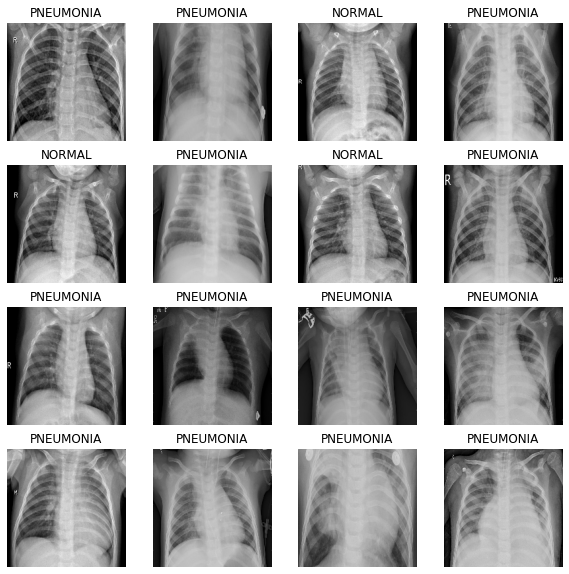

In [17]:
# 데이터를 시각화 해 봅시다. 
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())






----





# 3. 모델 구축하고 훈련하기 


* 우선, conv_block과 Dense block를 만들어 준 다음, 만든 블록들을 토대로 모델을 구축합니다. 


* train dataset의 불균형도 여기서 해결 해 줄 것입니다. 


* 모델이 구축되고, 데이터셋도 준비됬으니 모델을 훈련 시켜 줍니다. 

## &nbsp; &nbsp; 3-1 모델 구축하기

In [16]:
# conv_block 

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'), # conv 2번 
        tf.keras.layers.BatchNormalization(), # 배치 정규화
        tf.keras.layers.MaxPool2D() # maxpooling 
    ])
    
    return block

In [17]:
# dense_block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
#두 블록을 토대로 모델 생성 


def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model


## &nbsp; &nbsp; 3-2 데이터 imbalance 처리


* Weight balancing 이란 테크닉을 사용해서 imbalance를 처리했습니다. 
* trainging dataset의 각 데이터에서 loss를 계산할 때, 특정 클래스의 데이터에 더 큰 loss값을 갖도록 가중치를 부여하는 방법. 

In [19]:
# Weight balancing을 이용해 imbalance 처리 

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))


Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## &nbsp; &nbsp; 3-3 모델 훈련시키기

In [22]:
# 모델 학습 설정하기 

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [23]:
# 모델 훈련!
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )


Epoch 1/25
261/261 [==============================] - 87s 193ms/step - loss: 0.3728 - accuracy: 0.8259 - precision: 0.9512 - recall: 0.8077 - val_loss: 0.7629 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2401 - accuracy: 0.9071 - precision: 0.9699 - recall: 0.9030 - val_loss: 1.4069 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 190ms/step - loss: 0.2027 - accuracy: 0.9267 - precision: 0.9775 - recall: 0.9228 - val_loss: 0.3568 - val_accuracy: 0.8231 - val_precision: 0.8059 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 193ms/step - loss: 0.2043 - accuracy: 0.9215 - precision: 0.9737 - recall: 0.9192 - val_loss: 0.0868 - val_accuracy: 0.9760 - val_precision: 0.9907 - val_recall: 0.9765
Epoch 5/25
261/261 [==============================] - 52s 198ms/step - loss: 0.1903 - accura





----





# 4. 모델 성능 평가하기

## &nbsp; &nbsp; 4-1 결과 값 시각화 해보기! 

* 결과값을 시각화하여 학습 결과를 확인 해 봅시다. 

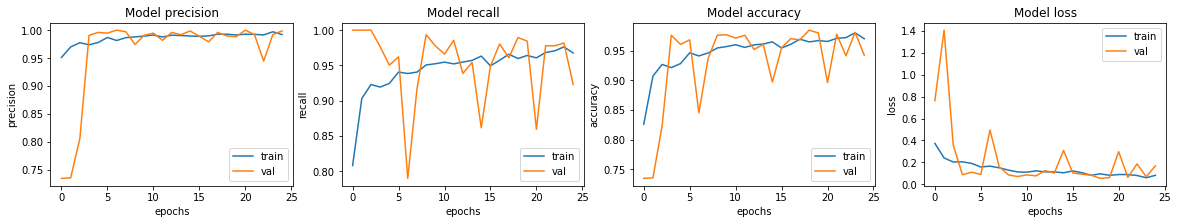

In [24]:
# for문을 이용해 각각의 값을 시각화 해 봅시다 :D 

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## &nbsp; &nbsp; 4-2 모델 평가하기! 

In [25]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 108ms/step - loss: 0.5974 - accuracy: 0.8686 - precision: 0.8532 - recall: 0.9538
Loss: 0.5974036455154419,
Accuracy: 0.8685897588729858,
Precision: 0.853210985660553,
Recall: 0.9538461565971375


* 모델을 구축 해 보고, 모델 성능까지 평가 해 보았다. 


* 모델 정밀도는 안정된 것처럼 보이긴 하나, 대체적으로 다른 부분에서 값이 급격하게 변화했다. 이건 오버피팅 되었단 의미로 해석 해 볼 수 있을것같다. 


* 전체적으로 train에 대한 값은 안정적으로 올랐으나, validation 수치가 불안정하다. 급격하게 뛴 부분lms 진행 시에 시각화 했던 그래프 보다, 더 불안정 하다. 어떻게 하면 모델 성능을 더 높히고, 안정적인 모델을 만들 수 있을 지 다음 부분에서 시도 해서 루브릭 평가 기준을 만족 시켜 보자! 





----





# 5. 모델 성능 향상해보기


* 모델의 성능을 올리기 위해서 어떤걸 시도 해 봐야할까? 
* 3-1 에서 만든 모델은 그대로 냅두고, 그걸 가져와서 사용할까? 아님 size를 바꾼 새 모델을 만들어서 여러 파라미터를 바꿔가면서 시험, 기록 해보자 

In [26]:
# 모델 성능 향상을 위한  


def build_model_new():
    model_new = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.1),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.1),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model_new

## &nbsp; &nbsp; 5-1 첫번째 시도 : drop out 수치 변경 + EarlyStopping 적용하기

1. 뉴스 요약봇 만들 때 써봤던 earlystopping 기능을 가져와, 모델 학습에 이용해 볼 것!

2. 이미 사용되어 있는 drop out의 설정 값을 바꾸거나 늘리고 줄이는 등의 변화를 줘 보기로 한다.


* drop out은 모델 설계시에, earlystopping은 모델 훈련 시에 변경 및 추가 해 줍니다.
* train data는 아직 따로 추가 해 주거나 한게 없기 때문에, 위쪽에서 선언한 걸 변경 없이 가져옵니다. 


In [20]:
# earlystopping을 가져옵니다. 
# patience = 기준이 되는 부분이 얼마 이상 증가하면 멈출지 정하는 부분 
# 값을 따로 빼서 각각 학습 시 원하는 만큼 줄 수 있게 해줬습니다. 
pati = 5
es = EarlyStopping(monitor='val_loss', patience=pati, verbose=1) 


In [30]:
# build_model_new() 변경된 drop out 수치가 적용되어있는 모델, 다른 수치는 동일합니다.
# 모델 학습을 설정합니다. 
# 모델 학습 설정하기 

with tf.device('/GPU:0'):
    model2 = build_model_new()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [31]:
# 기존과는 다른 수치로 적용 된 drop의 성능, 한번 볼까나! 

# 모델 훈련!

with tf.device('/GPU:0'):
    his_case_2 = model2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )


Epoch 1/25
261/261 [==============================] - 59s 192ms/step - loss: 0.3992 - accuracy: 0.7965 - precision: 0.9567 - recall: 0.7607 - val_loss: 0.5992 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 190ms/step - loss: 0.2213 - accuracy: 0.9155 - precision: 0.9752 - recall: 0.9097 - val_loss: 1.0342 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 191ms/step - loss: 0.2051 - accuracy: 0.9255 - precision: 0.9735 - recall: 0.9249 - val_loss: 0.1878 - val_accuracy: 0.9058 - val_precision: 0.8872 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 50s 192ms/step - loss: 0.1784 - accuracy: 0.9265 - precision: 0.9772 - recall: 0.9228 - val_loss: 0.2535 - val_accuracy: 0.9212 - val_precision: 0.9971 - val_recall: 0.8954
Epoch 5/25
261/261 [==============================] - 51s 195ms/step - loss: 0.1670 - accura

* 시각화도 해 봅시다. 

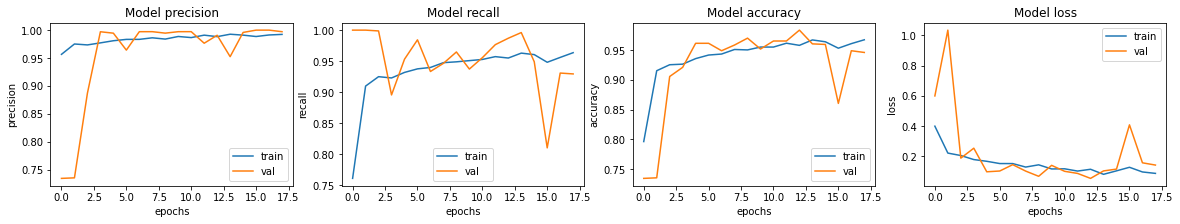

In [32]:
# for문을 이용해 각각의 값을 시각화 해 봅시다 :D 

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(his_case_2.history[met])
    ax[i].plot(his_case_2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

* 평가도 해 볼까요? 

In [33]:
# 다른 것도 함께 봐야하기 때문에 이름을 바꿔주었습니다

loss_case_2, accuracy_case_2, precision_case_2, recall_case_2 = model.evaluate(test_ds)
print(f'Loss: {loss_case_2},\nAccuracy: {accuracy_case_2},\nPrecision: {precision_case_2},\nRecall: {recall_case_2}')

39/39 [==============================] - 4s 108ms/step - loss: 0.5974 - accuracy: 0.8686 - precision: 0.8532 - recall: 0.9538
Loss: 0.5974037647247314,
Accuracy: 0.8685897588729858,
Precision: 0.853210985660553,
Recall: 0.9538461565971375


###  &nbsp; &nbsp;&nbsp; &nbsp; 5-1-1 drop_out : 0.5 + earlystopping val_loss, patience=2 󠁼󠁼󠁼󠁼


----

* drop_out을 사용해 과적합을 잡으려는걸, 오히려 더 과적합 하게 만들어버렸다. drop_out으로 솎아내지는 뉴런 수가 너무 많았던걸까..? 모델에 있는 drop_out 값은 원래대로 0.2 로 설정하고, drop_out을 하나 더 추가하는 식으로 한번 더 도전해보겠다. 



**<모델 훈련>**      
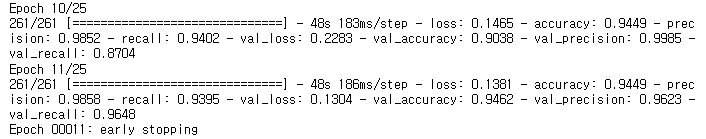         




**<시각화>**       
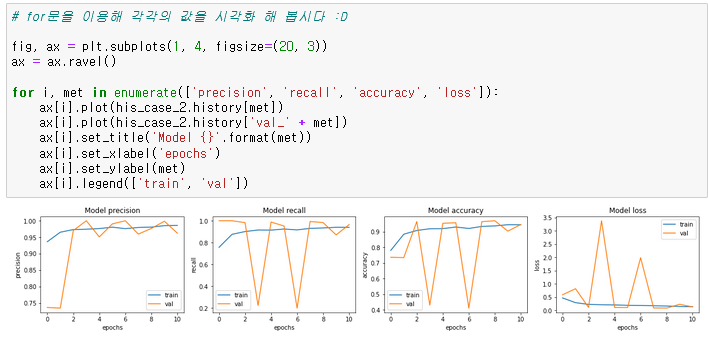      




**<평가>**    
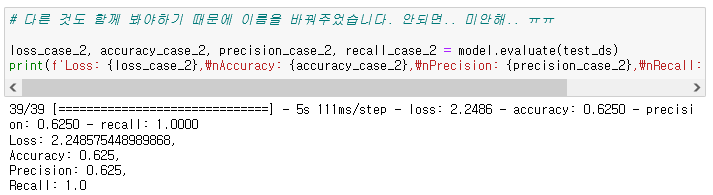      

###  &nbsp; &nbsp;&nbsp; &nbsp; 5-1-2 drop_out : 0.1, 0.4 + earlystopping val_loss, patience=2 , Conv2D 16->32 

* Conv2D 채널 수를 16에서 32로 변경하고, drop_out 수치도 함께 바꿔서 모델 생성을 해보니, 5-1-1 보단 훨씬 올라가고 내려가는 폭이 줄어들긴 했지만, loss는 2가 넘어버렸으며, recall 값은 1.0.. 오버피팅은 해결되지 않았다. 



**<모델>**    
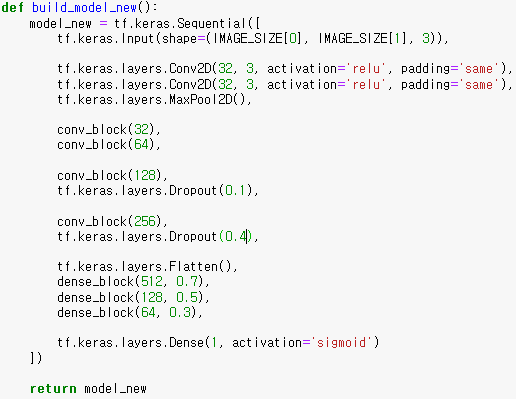    



**<모델 훈련>**    
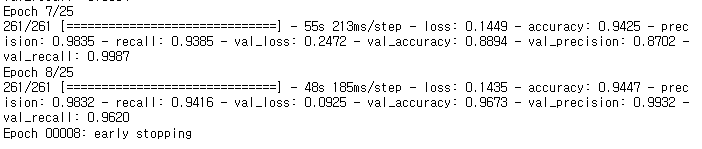    



**<시각화>**     
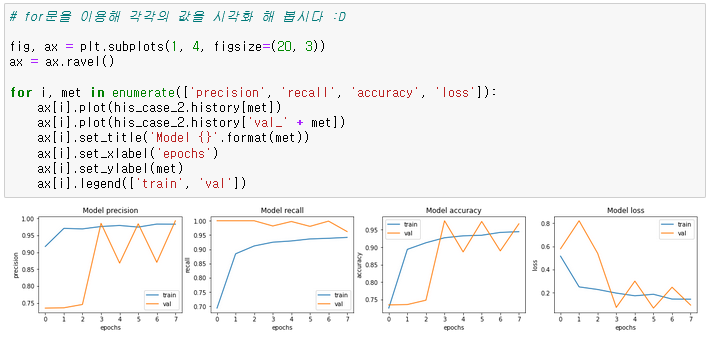



**<평가>**     
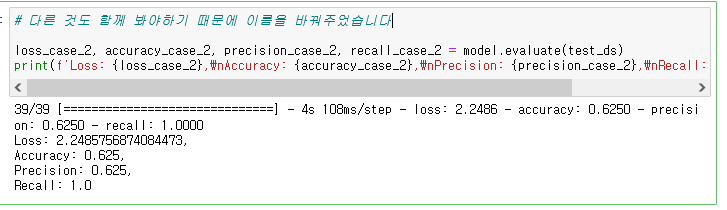

###  &nbsp; &nbsp;&nbsp; &nbsp; 5-1-3 drop_out : 0.1 + earlystopping val_loss, patience=5 , Conv2D filter 64


* 다른 방법으로, drop_out 값을 0.1, earlystopping의 patience를 2->5로 변경했고, Conv2D filter를 64로 조정하였다. filter가 아무리 늘어나도, 약 4000개의 불균형한 데이터셋으론  충분한 학습이 이루어 지지 않아, 모델이 성능 향상을 할 수 없단 점을 깨달았다. 





**<모델>**    
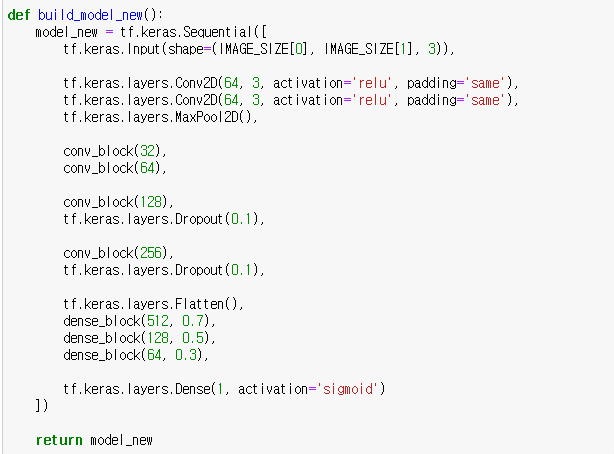       



**<모델 훈련>**    
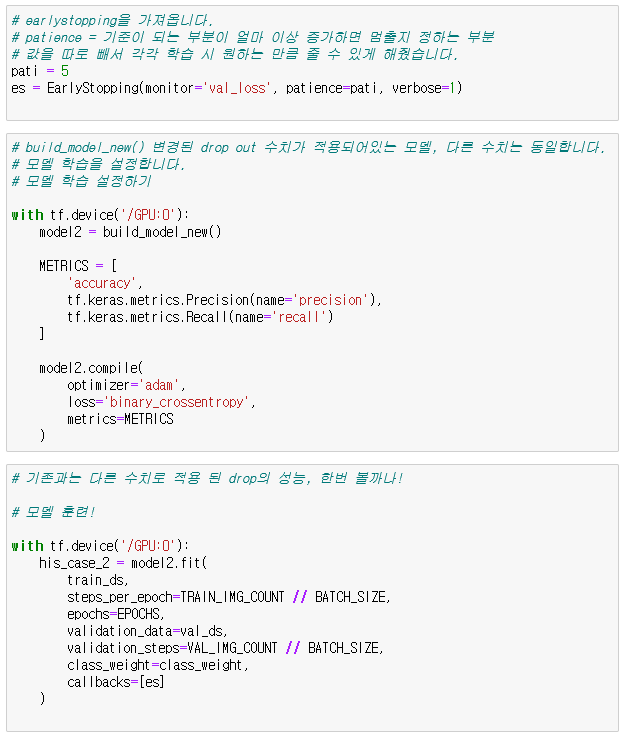    
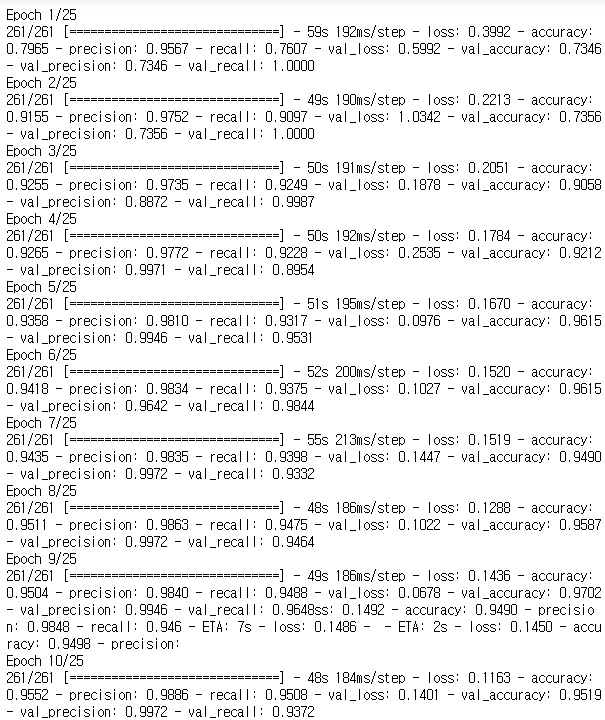      
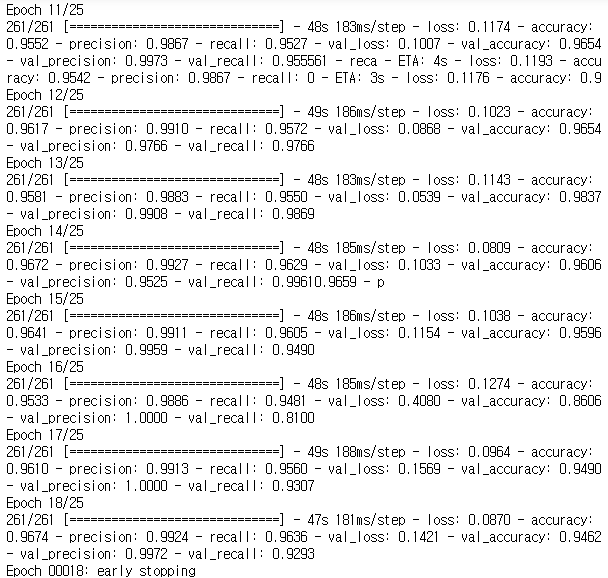



**<시각화>**     
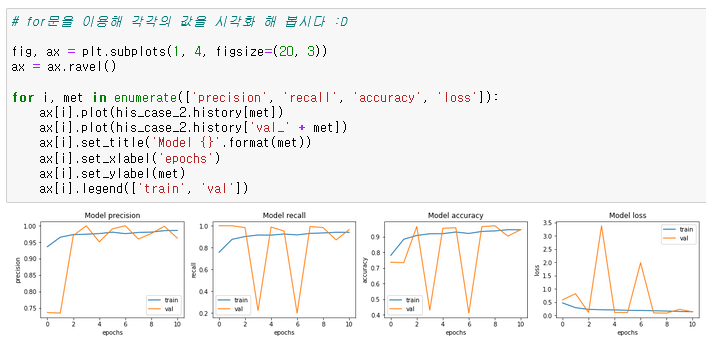



**<평가>**     
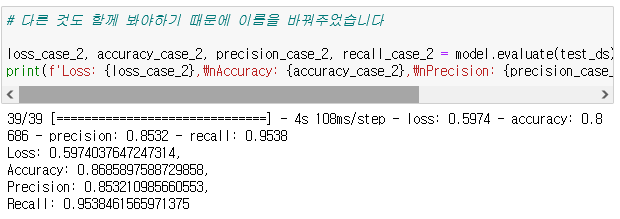

* 하지만 평가 부분에선 val의 모델 정확도가 학습이 진행되면서 train에 근접하고있다. 
* 정확도나, 다른 부분도 급격하게 변화했던 부분을 제외한다면 제일 처음 학습했던 모델보단 완만한 수치를 보이고 있다. 모델 정확성 만큼 다른 수치들도 조금만 더 평행했음 좋겠다. 조금 더 개량을 시도해보자!



----




## &nbsp; &nbsp; 5-2 두번째 시도 : Augmentation 적용,  Conv2D fliter 64, Callback - learningrate, Earlystopping patience = 3


* 단순히 파라미터만을 바꿔 보는 것이 답은 아니라는 결론을 토대로, 학습 데이터를 늘려보기로 한다. 다만, 폐렴 데이터를 쉽게 얻을 수 있는 것이 아니기 때문에 우선 LMS 상에 있던 해결 방법 - Data Agumentation을 적용해 보기로 한다. 
* augmentation 도입은 의료 데이터셋에는 더더욱 신중해야 한다고 설명하셨는데, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등의 효과가 오히려 판별하는데 방해가 될 수 있기 때문입니다. 그래서 이번 시간에는 좌우 반전 효과만 넣어보기로 합니다. 

* callback으로 learningrate도 가져와 모델의 학습량도 조절 해 보겠습니다.

### &nbsp;&nbsp;&nbsp;&nbsp; 5-2-1 data agumentation  train, test data에 적용하기 

In [65]:
# LearningRate
# scheduler 함수로 epoch가 10 이하면 0.0001의 학습률, 10 부터 최대 epoch까지 학습량을 조절합니다. 
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.1 * (10 - epoch))


cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [39]:
# data agumentation 적용 
# 좌우 반전 정도의 agumentation만 적용하는 코드랍니다.

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training_agu(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_3 = prepare_for_training_agu(train_ds)
val_ds_3 = prepare_for_training_agu(val_ds)

### &nbsp;&nbsp;&nbsp;&nbsp; 5-2-2 data 시각화 


* 시각화를 시도하는 과정에서 커널이 자꾸 죽어버려 생략하였다.


* 처음에 시도했을땐 별 문제 없다가, 지금에와서 문제가 생기는 이유는 무슨 이유일까.. 

### &nbsp;&nbsp;&nbsp;&nbsp; 5-2-3 모델을 훈련 하고 비교해보기 


* 5-1에서 파라미터를 조금씩 바꿔서 해 본 결과, 그렇게 향상과 그래프 안정에 큰 역할을 주지 못 한다고 판단했기 때문에 이번엔 3-1에서 구축한 모델과 동일한 설정으로 모델을 만들어 사용합니다. 

* train data와 val_data는 agument를 적용한 부분을 가져와야 합니다! 


* 5-1에서 했던 시도들 보다 전체적으로 심하게 꺾이는 부분은 줄어든것 같다. 정확도와 recall이 점점 떨어지긴 했지만, 모델 평가 부분에서 다른 모델들 보다 성적이 좋았던걸 보면 callback learnning rate 조절이 잘 된게 아닐까 예측해본다:)! 

In [74]:
def agu_build_model():
    agu_model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return agu_model

In [75]:
# 모델 학습 설정하기 

with tf.device('/GPU:0'):
    model3 = agu_build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [76]:
# 모델 훈련!
pati = 2

with tf.device('/GPU:0'):
    his_case_agu = model3.fit(
        train_ds_3,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_3,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es, cb]
    )

Epoch 1/25
261/261 [==============================] - 59s 193ms/step - loss: 0.4220 - accuracy: 0.8034 - precision: 0.9475 - recall: 0.7789 - val_loss: 0.6062 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 192ms/step - loss: 0.2695 - accuracy: 0.8906 - precision: 0.9692 - recall: 0.8809 - val_loss: 1.0667 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 51s 194ms/step - loss: 0.2165 - accuracy: 0.9128 - precision: 0.9741 - recall: 0.9071 - val_loss: 0.3775 - val_accuracy: 0.8250 - val_precision: 0.8074 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 51s 196ms/step - loss: 0.2047 - accuracy: 0.9205 - precision: 0.9767 - recall: 0.9151 - val_loss: 0.2923 - val_accuracy: 0.8990 - val_precision: 1.0000 - val_recall: 0.8622
Epoch 5/25
261/261 [==============================] - 51s 196ms/step - loss: 0.1885 - accura

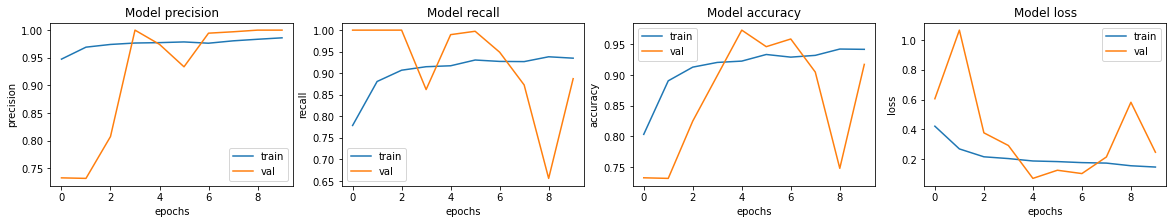

In [77]:
# 학습 시각화 
# for문을 이용해 각각의 값을 시각화 해 봅시다 :D 

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(his_case_agu.history[met])
    ax[i].plot(his_case_agu.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [78]:
# 모델 평가하기! 

loss_case_3, accuracy_case_3, precision_case_3, recall_case_3 = model3.evaluate(test_ds)
print(f'Loss: {loss_case_3},\nAccuracy: {accuracy_case_3},\nPrecision: {precision_case_3},\nRecall: {recall_case_3}')

39/39 [==============================] - 5s 120ms/step - loss: 0.3715 - accuracy: 0.8670 - precision: 0.8828 - recall: 0.9077
Loss: 0.37148019671440125,
Accuracy: 0.8669871687889099,
Precision: 0.8827930092811584,
Recall: 0.9076923131942749






----





# 📋 회고

* 이번 노드는.. 데이터가 기본 10,000 개 넘어가던 다른 노드와는 달리 데이터가 몹시 적어서 모델 성능이 확 좋아지지 않아 정확도 맞추기가 힘들었던것 같다. 덕분에 하이퍼 파라미터보단 다른 기능을 붙여 모델 성능을 개선 해 나가는 것이 중요하단 사실을 배웠다. 


* 모델의 레이어를 추가할 때, 함수로 선언해서 적용하는 방법은 다른 한 파일에 따로 저장해서 한줄로 불러올 수 있게 할 수 있어 코드가 줄어들테니 꼭 한번 더 연습 해 봐야겠다. import로 불러오기만 하면 코드도 그리 길지 않고, 가독성도 좋을테니 말이다:) 


* 5-2-2 data 시각화 부분에서, agument로 반전된 이미지를 출력하고 싶었으나, 커널이 자꾸 죽는 문제가 발생하여 코드를 아예 삭제 했다. 잘 반전됬는지 한번 더 확인 해보고, 데이터 수가 얼마나 증가하였는지도 함께 파악했다면 더 확실하게 알 수 있었을텐데 구현되지 못 해서 매우 아쉬웠다. 


* lms와 deepML 풀잎에서 들어보기만 했던 learning rate를 이번기회에 적용해 보았다. lms에 있던 기능외의 다른것을 인터넷에서 찾아 가져와 적용해 본건 거의 손에 꼽았던것 같은데.. learning rate에 관해 구글에서 검색해서 사용법과 넣을수 있는 인자 등을 검색 해보고, 사용 방법도 찾아 그대로 적용해 보았다. 검색 하면서 느꼈던 점은, 내가 찾으려는 기능을 가지고 무엇을 할 것이고, 필요한 기능이 무엇일까를 먼저 생각 해 두고 검색하면 찾으려는 부분을 조금 더 수월하게 찾을 수 있단 점을 배웠다. 


* 하지만, 지금 내가 시도해 본 과정으로도 학습 시각 데이터에 급격한 부분을 해소할 순 없었다. 조금 더 찾아봤었더라면 해결 해볼 수도 잇었을텐데.. 이번 기회에 검색 목적을 잡고 검색해보자! 라는 걸 깨달았으니, 다음 노드를 시도할땐 무엇을 하고싶고, 어떤걸 시도 해보고 싶은지를 미리 정해놓고 해 보면 원하는 기능, 다양한 방법을 시도해 볼 수 있을것이다. 







----





# 🔗 참고 페이지

[mini-batch 설명](https://acdongpgm.tistory.com/202)

### 모델 개선 관련


* [적은양의 데이터셋으로 강력한 이미지 분류 모델 설계하기](https://keraskorea.github.io/posts/2018-10-24-little_data_powerful_model/)



* [callback - LearningRateScheduler](https://jins-sw.tistory.com/27)


* [LearnningRate](https://keras.io/api/callbacks/learning_rate_scheduler/)